# Initializing SparkSession

In [200]:
import os 
import findspark
import pyspark
from pyspark.sql import SparkSession
findspark.init()
from pyspark.sql.functions import *

spark = SparkSession.builder.master("local[*]").appName("SparkIsGreat").getOrCreate()

# Reading Ireland Rental Data 

In [201]:
df_data = spark.read.format("csv").option("header","true").option("inferSchema","True").load("/Users/swapnilbhoite/Downloads/RIA02.20230309T100358.csv")

# Dropping columns not required and displaying data details

In [202]:
df_data.printSchema()
df = df_data.drop("STATISTIC Label", "UNIT")
print("Record Count: ", df_data.count())
df_data.printSchema()
df.show()


root
 |-- STATISTIC Label: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Number of Bedrooms: string (nullable = true)
 |-- Property Type: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)

Record Count:  262248
root
 |-- STATISTIC Label: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Number of Bedrooms: string (nullable = true)
 |-- Property Type: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)

+----+------------------+------------------+--------------------+------+
|Year|Number of Bedrooms|     Property Type|            Location| VALUE|
+----+------------------+------------------+--------------------+------+
|2008|      All bedrooms|All property types|              Carlow|747.88|
|2008|      All bedrooms|All property types|         Carlow Town|811.72|
|2008|      All b

# Bundling the data county-wise rather than city/town wise

In [204]:
dataframe2 = df.withColumn('County', split(df['Location'], ',').getItem(1)).drop("Location")
dataframe3 = dataframe2.na.drop()
dataframe3.show()
print("Updated record count: ",dataframe3.count())
dataframe3.printSchema()

+----+------------------+------------------+-------+-------+
|Year|Number of Bedrooms|     Property Type|  VALUE| County|
+----+------------------+------------------+-------+-------+
|2008|      All bedrooms|All property types| 711.35| Carlow|
|2008|      All bedrooms|All property types|  717.1| Carlow|
|2008|      All bedrooms|All property types| 598.74|  Cavan|
|2008|      All bedrooms|All property types| 598.45|  Cavan|
|2008|      All bedrooms|All property types| 481.83|  Cavan|
|2008|      All bedrooms|All property types| 530.63|  Cavan|
|2008|      All bedrooms|All property types| 661.38|  Cavan|
|2008|      All bedrooms|All property types| 624.92|  Cavan|
|2008|      All bedrooms|All property types| 684.84|  Clare|
|2008|      All bedrooms|All property types| 722.54|  Clare|
|2008|      All bedrooms|All property types| 666.26|  Clare|
|2008|      All bedrooms|All property types| 756.08|  Clare|
|2008|      All bedrooms|All property types| 991.98|   Cork|
|2008|      All bedrooms

# Encoding and indexing the string data type to be used in ML Model

In [190]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# Create StringIndexer
County_indexer = StringIndexer(inputCol='County', outputCol='County_index')

# Create a OneHotEncoder
County_encoder = OneHotEncoder(inputCol='County_index', outputCol='County_fact')

# Create StringIndexer
Bedroom_indexer = StringIndexer(inputCol='Number of Bedrooms', outputCol='Number of Bedrooms_index')

# Create a OneHotEncoder
Bedroom_encoder = OneHotEncoder(inputCol='Number of Bedrooms_index', outputCol='Bedrooms_fact')

# Create StringIndexer
Property_indexer = StringIndexer(inputCol='Property Type', outputCol='Property Type_index')

# Create a OneHotEncoder
Property_encoder = OneHotEncoder(inputCol='Property Type_index', outputCol='Property_fact')

# Creating VectorAssembler

In [191]:
from pyspark.ml.feature import VectorAssembler

# Make a VectorAssembler
vec_assembler = VectorAssembler(inputCols=['Year', 'County_fact', 'VALUE','Bedrooms_fact','Property_fact'],outputCol='features').setHandleInvalid("keep")

from pyspark.ml import Pipeline

# Make the pipeline
flights_pipe = Pipeline(stages=[County_indexer, County_encoder,Bedroom_indexer,Bedroom_encoder,Property_indexer,Property_encoder, vec_assembler])

# Dividing the data for training and testing

In [206]:
piped_data = flights_pipe.fit(dataframe3).transform(dataframe3)
training, test = piped_data.randomSplit([.95, .05])
print("training records: " , training.count())
print("test records: ", test.count())

training records:  65703
test records:  3441


# Using Random Forest Model

In [193]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'County_index')
rfModel = rf.fit(training)
predictionsrf = rfModel.transform(test)
#predictionsrf.show(25)

## Calculating accuracy of the model

In [207]:
accuracyrf = predictionsrf.filter(predictionsrf.County_index == predictionsrf.prediction).count() / float(predictionsrf.count())
print("Accuracy : ",accuracyrf)
rf = predictionsrf.select("County_index","prediction")
rf.show()

Accuracy :  0.6681071737251513
+------------+----------+
|County_index|prediction|
+------------+----------+
|        41.0|       0.0|
|        39.0|       0.0|
|         4.0|       4.0|
|         0.0|       0.0|
|         2.0|       2.0|
|         9.0|       9.0|
|         7.0|       7.0|
|        16.0|       0.0|
|         1.0|       1.0|
|        43.0|       0.0|
|        15.0|      15.0|
|         9.0|       9.0|
|         5.0|       5.0|
|        30.0|       0.0|
|         5.0|       5.0|
|         7.0|       7.0|
|        12.0|      12.0|
|        33.0|       0.0|
|        13.0|      13.0|
|         3.0|       3.0|
+------------+----------+
only showing top 20 rows



# Using Decision Tree ML model


In [208]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'County_index')
dtModel = dt.fit(training)
predictionsdt = dtModel.transform(test)

## Calculating accuracy of the model

In [209]:
accuracydt = predictionsdt.filter(predictionsdt.County_index == predictionsdt.prediction).count() / float(predictionsdt.count())
print("Accuracy : ",accuracydt)
dt = predictionsdt.select("County_index","prediction")
dt.show()
dt.printSchema()

Accuracy :  0.3612321999418774
+------------+----------+
|County_index|prediction|
+------------+----------+
|        11.0|       5.0|
|         6.0|       5.0|
|        26.0|       5.0|
|         3.0|       3.0|
|         3.0|       3.0|
|         3.0|       3.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|        16.0|       5.0|
|        31.0|       5.0|
|        31.0|       5.0|
|        28.0|       5.0|
|        24.0|       5.0|
|        11.0|       5.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         4.0|       4.0|
|        17.0|       5.0|
|         0.0|       0.0|
+------------+----------+
only showing top 20 rows

root
 |-- County_index: double (nullable = false)
 |-- prediction: double (nullable = false)



# Plotting actual values vs predicated 

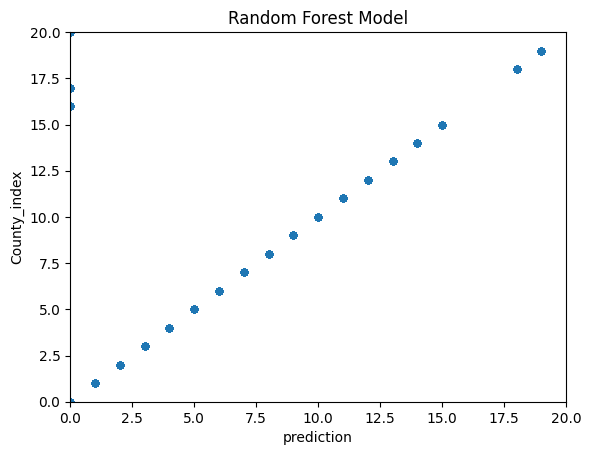

In [210]:
import matplotlib.pyplot as plot

rf1.plot.scatter(x="prediction", y="County_index")
plot.title("Random Forest Model")
plot.xlim(0, 20)
plot.ylim(0, 20)
plot.show()

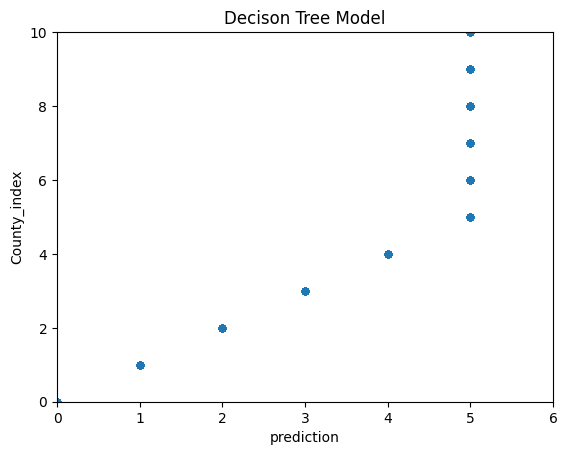

In [211]:
dt1.plot.scatter(x="prediction", y="County_index")
plot.title("Decison Tree Model")
plot.xlim(0, 6)
plot.ylim(0, 10)
plot.show()
